# Introduction

In [1]:
# Import necessary packages

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

from yellowbrick.cluster import KElbowVisualizer

In [2]:
# function to test KMeans at various k
def optimal_kmeans(dataset, start=2, end=11):
    
    n_clu = []
    km_ss = []

    for n_clusters in range(start, end):

        kmeans = KMeans(n_clusters=n_clusters)
        labels = kmeans.fit_predict(dataset)

        silhouette_avg = round(silhouette_score(dataset, labels, 
                                                random_state=1), 3)
        km_ss.append(silhouette_avg)
        n_clu.append(n_clusters)

        print("No. Clusters: {}, Silhouette Score: {}, Change from Previous Cluster: {}".format(
            n_clusters, 
            silhouette_avg, 
            (km_ss[n_clusters - start] - km_ss[n_clusters - start - 1]).round(3)))

        if n_clusters == end - 1:
            plt.figure(figsize=(4,4))

            plt.title('Silhouette Score Elbow for KMeans Clustering')
            plt.xlabel('k')
            plt.ylabel('silhouette score')
            sns.pointplot(x=n_clu, y=km_ss)
            plt.savefig('silhouette_score.png', format='png', dpi=300,
                        pad_inches=2.0)
            plt.tight_layout()
            plt.show()

In [3]:
#function to calculate and plot specified # of clusters
def kmeans(df, clusters_number):

    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(df)

    cluster_labels = kmeans.labels_
        
    df_new = df.assign(Cluster = cluster_labels)
    
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df)
    
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], 
                    hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new, cluster_labels

## EDA

First of all, lets take a look at each table to see what's there.

In [4]:
import pymysql
  
conn = pymysql.connect(
        host='localhost',
        user='root', 
        password = "Krithick37!",
        db='instacart',
        )
      
cur = conn.cursor()

### Orders table

This table contains information about orders placed to Instacart. Each row represents an order.

In [5]:
cur.execute("""
    SELECT *
    FROM orders1
            ;""")
orders = pd.DataFrame(cur.fetchall())
orders.columns = [x[0] for x in cur.description]
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2398795,1,prior,2,3,7,15
1,473747,1,prior,3,3,12,21
2,2254736,1,prior,4,4,7,29
3,431534,1,prior,5,4,15,28
4,3367565,1,prior,6,2,7,19


In [6]:
# View summary stats
orders.describe()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,5.074690e+05,507469.000000,507469.000000,507469.000000,507469.000000,507469.000000
mean,1.711220e+06,16302.152969,18.229413,2.783963,13.432939,11.101153
std,9.874477e+05,9377.025340,17.863900,2.043034,4.212877,9.183229
min,6.000000e+00,1.000000,2.000000,0.000000,0.000000,0.000000
25%,8.572090e+05,8137.000000,6.000000,1.000000,10.000000,4.000000
50%,1.710605e+06,16340.000000,12.000000,3.000000,13.000000,7.000000
75%,2.566433e+06,24366.000000,25.000000,5.000000,16.000000,15.000000
max,3.421083e+06,32567.000000,100.000000,6.000000,23.000000,30.000000


In [7]:
# View column datatypes and observation counts
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507469 entries, 0 to 507468
Data columns (total 7 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   order_id                507469 non-null  int64 
 1   user_id                 507469 non-null  int64 
 2   eval_set                507469 non-null  object
 3   order_number            507469 non-null  int64 
 4   order_dow               507469 non-null  int64 
 5   order_hour_of_day       507469 non-null  int64 
 6   days_since_prior_order  507469 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 27.1+ MB


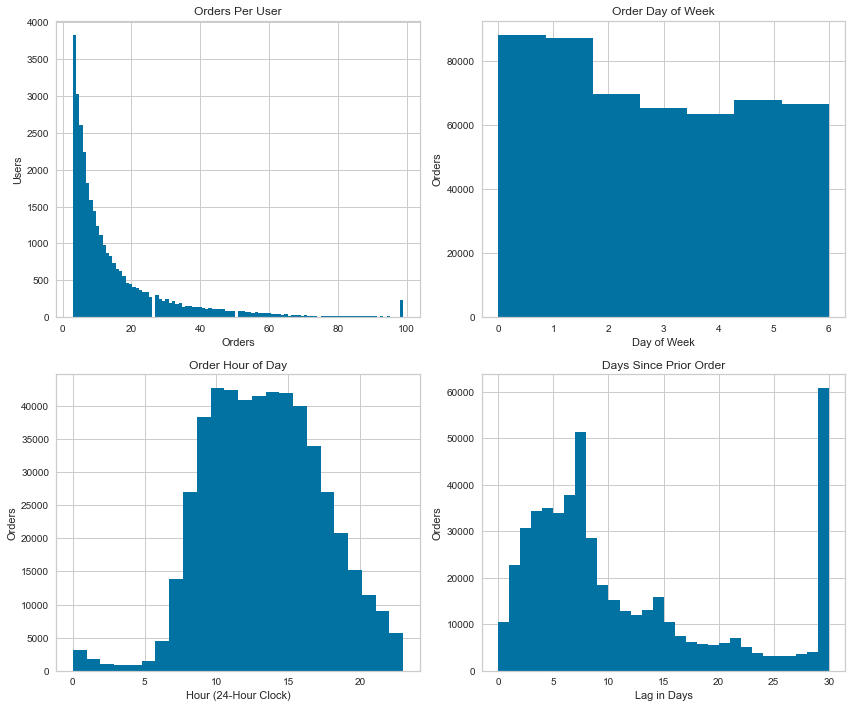

In [8]:
# Plot histograms of features of interest
fig, axes = plt.subplots(2, 2, figsize=(12,10))

ax0 = axes[0,0]
ax0.hist(orders.user_id.value_counts(), bins=100)
ax0.set_title('Orders Per User')
ax0.set_xlabel('Orders')
ax0.set_ylabel('Users')

ax1 = axes[0,1]
ax1.hist(orders.order_dow, bins=7)
ax1.set_title('Order Day of Week')
ax1.set_xlabel('Day of Week')
ax1.set_ylabel('Orders')

ax2 = axes[1,0]
ax2.hist(orders.order_hour_of_day, bins=24)
ax2.set_title('Order Hour of Day')
ax2.set_xlabel('Hour (24-Hour Clock)')
ax2.set_ylabel('Orders')

ax3 = axes[1,1]
ax3.hist(orders.days_since_prior_order, bins=30)
ax3.set_title('Days Since Prior Order')
ax3.set_xlabel('Lag in Days')
ax3.set_ylabel('Orders')

plt.tight_layout()
plt.show();


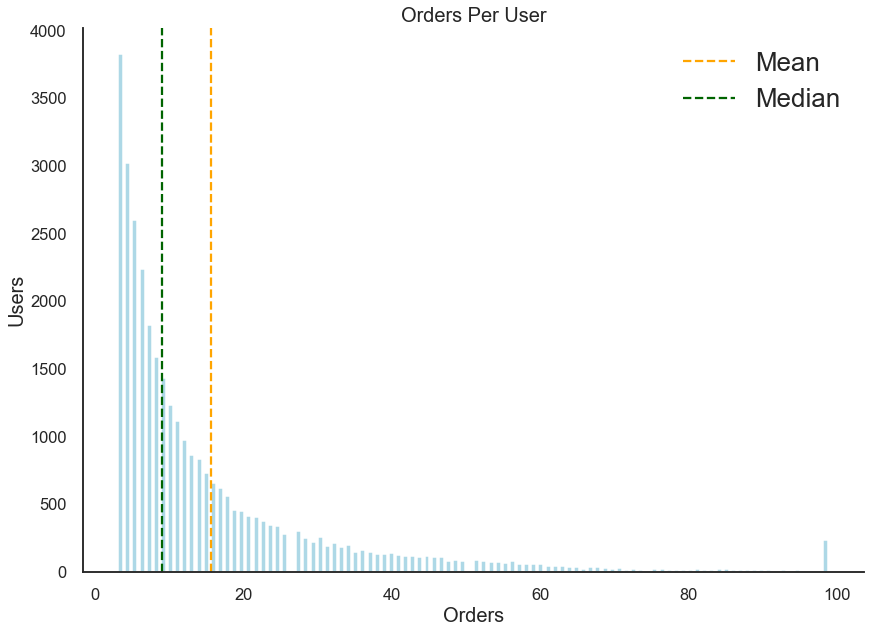

In [9]:
sns.set_context('talk')
sns.set_style('white')

# Visualize orders per customer with mean and median
plt.figure(figsize=(14,10))
plt.hist(orders.user_id.value_counts(), bins=100, rwidth=0.7, color='lightblue')
plt.axvline(orders.user_id.value_counts().mean(), color='orange', 
            linestyle='--', label='Mean')
plt.axvline(orders.user_id.value_counts().median(), color='darkgreen', 
            linestyle='--', label='Median')
plt.title('Orders Per User', fontdict={'fontsize': 20})
plt.xlabel('Orders',fontdict={'fontsize': 20})
plt.ylabel('Users',fontdict={'fontsize': 20})
plt.legend(fontsize = 'x-large')
sns.despine()
#plt.savefig('orders_per_user.png', dpi=300, pad_inches=0.5)
plt.show();

In [10]:
# Print mean and median
print('Mean orders per customer:', orders.user_id.value_counts().mean())
print('Median orders per customer:', orders.user_id.value_counts().median())

Mean orders per customer: 15.582307243528726
Median orders per customer: 9.0


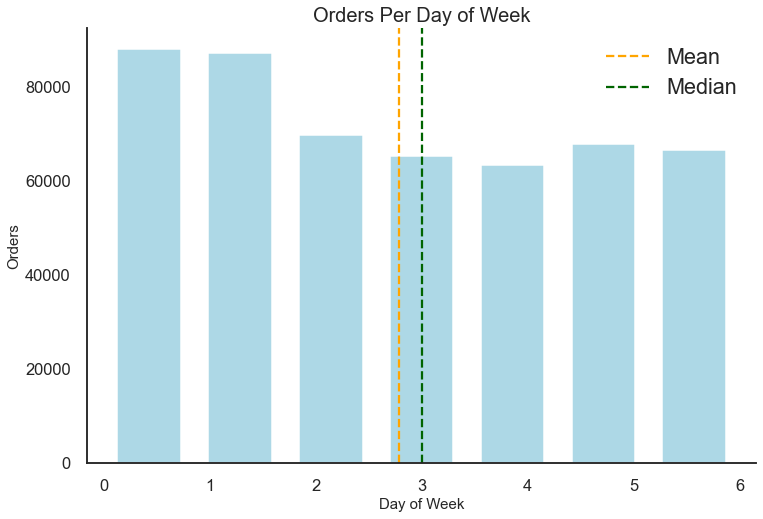

In [11]:
# Visualize orders by day of week
plt.figure(figsize=(12,8))
plt.hist(orders.order_dow, bins=7, rwidth=0.7,color='lightblue')
plt.axvline(orders.order_dow.mean(), color='orange', 
            linestyle='--', label='Mean')
plt.axvline(orders.order_dow.median(), color='darkgreen', 
            linestyle='--', label='Median')
plt.title('Orders Per Day of Week', fontdict={'fontsize': 20})
plt.xlabel('Day of Week',fontdict={'fontsize': 15})
plt.ylabel('Orders',fontdict={'fontsize': 15})
plt.legend(fontsize = 'large')
sns.despine()
#plt.savefig('orders_per_day.png', dpi=300, pad_inches=0.5)
plt.show();

In [12]:
# Print mean and median
print('Mean order day:', orders.order_dow.mean())
print('Median order day:', orders.order_dow.median())

Mean order day: 2.7839631583407067
Median order day: 3.0


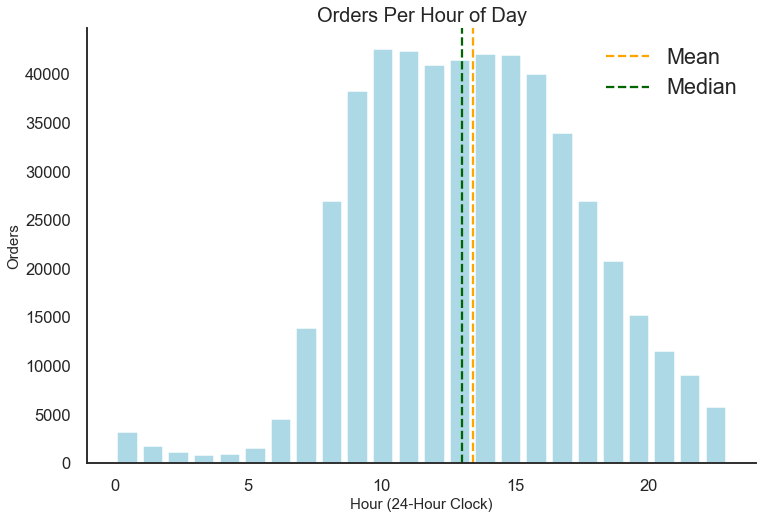

In [13]:
# Visualize orders by hour of day
plt.figure(figsize=(12,8))
plt.hist(orders.order_hour_of_day, bins=24,rwidth=0.8, color='lightblue')
plt.axvline(orders.order_hour_of_day.mean(), color='orange', 
            linestyle='--', label='Mean')
plt.axvline(orders.order_hour_of_day.median(), color='darkgreen', 
            linestyle='--', label='Median')
plt.title('Orders Per Hour of Day', fontdict={'fontsize': 20})
plt.xlabel('Hour (24-Hour Clock)', fontdict={'fontsize': 15})
plt.ylabel('Orders', fontdict={'fontsize': 15})
plt.legend(fontsize = 'large')
sns.despine()
#plt.savefig('orders_per_hour.png', dpi=300, pad_inches=0.5)
plt.show();

In [14]:
# Print mean and median
print('Mean order hour:', orders.order_hour_of_day.mean())
print('Median order hour:', orders.order_hour_of_day.median())

Mean order hour: 13.4329387607913
Median order hour: 13.0


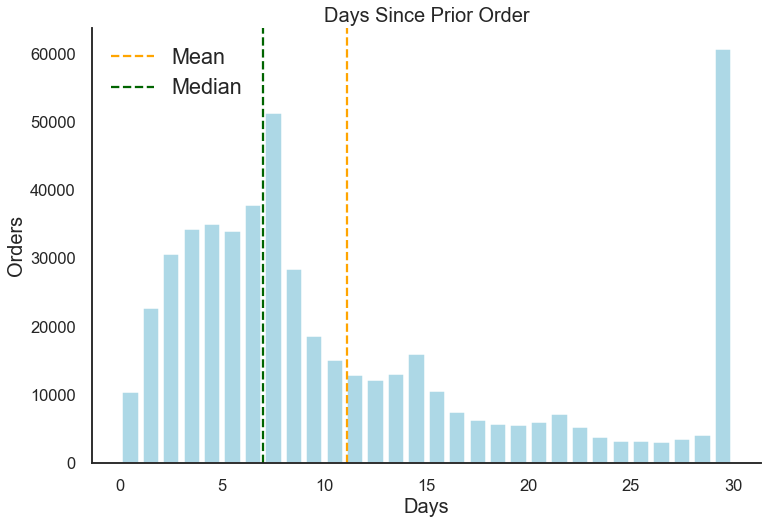

In [15]:
# Visualize orders by hour of day
plt.figure(figsize=(12,8))
plt.hist(orders.days_since_prior_order, bins=30, rwidth=0.8, color='lightblue')
plt.axvline(orders.days_since_prior_order.mean(), color='orange', 
            linestyle='--', label='Mean')
plt.axvline(orders.days_since_prior_order.median(), color='darkgreen', 
            linestyle='--', label='Median')
plt.title('Days Since Prior Order', fontdict={'fontsize': 20})
plt.xlabel('Days', fontdict={'fontsize': 20})
plt.ylabel('Orders', fontdict={'fontsize': 20})
plt.legend(fontsize = 'large')
sns.despine()
plt.show();

In [16]:
# Print mean and median
print('Mean lag:', orders.days_since_prior_order.mean())
print('Median lag:', orders.days_since_prior_order.median())

Mean lag: 11.101152976832083
Median lag: 7.0


### Order_products table

This table presents the products in each order. Because the table contains over 3 million rows, I'm going to limit my query to avoid having to load all of that into memory.

In [17]:
order_products = pd.read_csv("order_products__prior.csv")

order_products.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [18]:
# Count orders in this sample
len(order_products.order_id.value_counts())


3214874

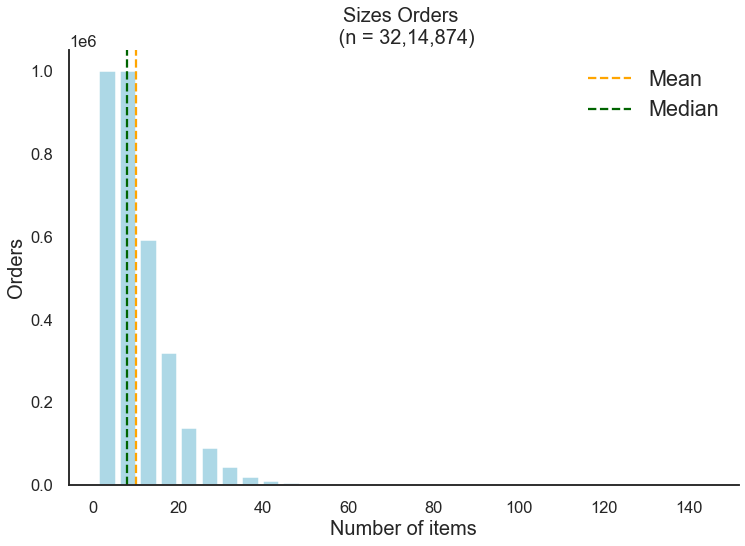

In [19]:
# Plot histogram of products per order
plt.figure(figsize=(12,8))
plt.hist(order_products.order_id.value_counts(), bins=30, rwidth=0.8,color='lightblue')
plt.axvline(order_products.order_id.value_counts().mean(), color='orange', 
            linestyle='--', label='Mean')
plt.axvline(order_products.order_id.value_counts().median(), 
            color='darkgreen', linestyle='--', label='Median')
plt.title('Sizes Orders \n (n = 32,14,874)', fontdict={'fontsize': 20})
plt.xlabel('Number of items', fontdict={'fontsize': 20})
plt.ylabel('Orders', fontdict={'fontsize': 20})
plt.legend(fontsize = 'large')
sns.despine()
# plt.savefig('order_size.png', dpi=300, pad_inches=0.5)
plt.show();

In [20]:
# Print mean and median
print('Mean size of orders:', order_products.order_id.value_counts().mean())
print('Median size of orders:', order_products.order_id.value_counts().median())

Mean size of orders: 10.088883421247614
Median size of orders: 8.0


In [21]:
order_products.order_id.value_counts()

1564244    145
790903     137
61355      127
2970392    121
2069920    116
          ... 
1515         1
2112933      1
2315126      1
483627       1
1771976      1
Name: order_id, Length: 3214874, dtype: int64

In [22]:
order_sizes = order_products.groupby("order_id")["product_id"].count()

order_sizes.head()

order_id
2     9
3     8
4    13
5    26
6     3
Name: product_id, dtype: int64

In [23]:
# Check count of orders represented
len(order_sizes)

3214874

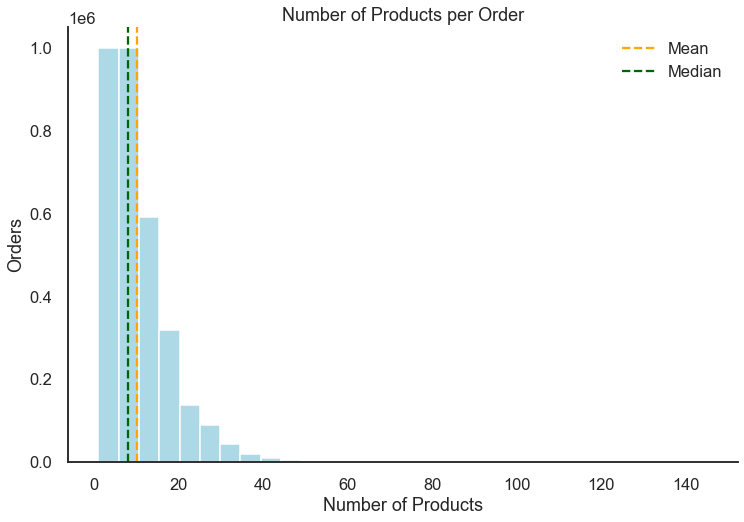

In [24]:
# Plot histogram of products per order
plt.figure(figsize=(12,8))
plt.hist(order_products.groupby("order_id")["product_id"].count(), bins=30, color='lightblue')
plt.axvline(order_products.groupby("order_id")["product_id"].count().mean(), color='orange', 
            linestyle='--', label='Mean')
plt.axvline(order_products.groupby("order_id")["product_id"].count().median(), 
            color='darkgreen', linestyle='--', label='Median')
plt.title('Number of Products per Order')
plt.xlabel('Number of Products')
plt.ylabel('Orders')
plt.legend()
sns.despine()
#plt.savefig('order_size.png', dpi=300, pad_inches=0.5)
plt.show();

# Plot histogram of products per order
plt.figure(figsize=(12,8))
plt.hist(order_sizes.num_products, bins=30, color='lightgreen')
plt.axvline(order_sizes.num_products.mean(), color='orange', 
            linestyle='--', label='Mean')
plt.axvline(order_sizes.num_products.median(), 
            color='darkgreen', linestyle='--', label='Median')
plt.title('Number of Products per Order')
plt.xlabel('Number of Products')
plt.ylabel('Orders')
plt.yticks([0,2e4, 4e4, 6e4, 8e4], ['0', '20k', '40k', '60k', '80k'])
plt.legend()
sns.despine()
plt.savefig('order_size.png', dpi=300, pad_inches=0.5)
plt.show();

In [25]:
# Print mean and median
print('Mean order size:', order_sizes.mean())
print('Median order size:', order_sizes.median())

Mean order size: 10.088883421247614
Median order size: 8.0


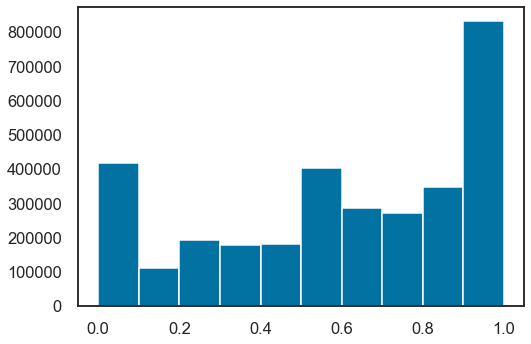

In [26]:
# Plot histogram of reorder rates per order
plt.hist(order_products.groupby('order_id')['reordered'].mean());

### Products table

This table contains identifying information on each product that customers can order.

In [27]:
# Query the products table and load the data
cur.execute("""
    SELECT *
    FROM products
    WHERE aisle_id <135  
    AND department_id <25;""")
products = pd.DataFrame(cur.fetchall())
products.columns = [x[0] for x in cur.description]
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,3,Robust Golden Unsweetened Oolong Tea,94,7
2,5,Green Chile Anytime Sauce,5,13
3,6,Dry Nose Oil,11,11
4,8,Cut Russet Potatoes Steam N' Mash,116,1


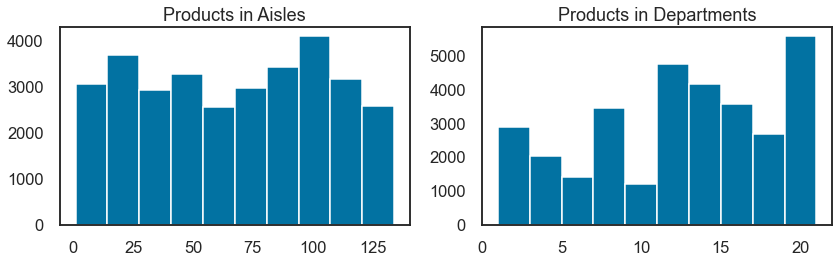

In [28]:
# Plot histograms of counts of products per aisle, department
fig, axes = plt.subplots(1, 2, figsize=(12,4))

ax0 = axes[0]
ax0.hist(products.aisle_id)
ax0.set_title('Products in Aisles')

ax1 = axes[1]
ax1.hist(products.department_id)
ax1.set_title('Products in Departments')

plt.tight_layout()
plt.show();

In [29]:
# View datatypes and observation counts
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31657 entries, 0 to 31656
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     31657 non-null  int64 
 1   product_name   31657 non-null  object
 2   aisle_id       31657 non-null  int64 
 3   department_id  31657 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 989.4+ KB


### Aisles table

This table contains information about the aisles where products may be located.

In [30]:
# Query the aisles table and load the data
cur.execute("""
    SELECT *
    FROM aisles
    where aisle_id < 135;""")
aisles = pd.DataFrame(cur.fetchall())
aisles.columns = [x[0] for x in cur.description]
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,4,instant foods
3,5,marinades meat preparation
4,6,other


In [31]:
# View all aisle names
[name for name in aisles.aisle]

['prepared soups salads',
 'specialty cheeses',
 'instant foods',
 'marinades meat preparation',
 'other',
 'packaged meat',
 'bakery desserts',
 'pasta sauce',
 'kitchen supplies',
 'cold flu allergy',
 'fresh pasta',
 'prepared meals',
 'tofu meat alternatives',
 'packaged seafood',
 'fresh herbs',
 'baking ingredients',
 'bulk dried fruits vegetables',
 'oils vinegars',
 'oral hygiene',
 'packaged cheese',
 'hair care',
 'popcorn jerky',
 'fresh fruits',
 'soap',
 '2474',
 'beers coolers',
 'red wines',
 'honeys syrups nectars',
 'latino foods',
 'packaged produce',
 'kosher foods',
 'frozen meat seafood',
 'poultry counter',
 'butter',
 'ice cream ice',
 'frozen meals',
 'seafood counter',
 'dog food care',
 'cat food care',
 'frozen vegan vegetarian',
 'buns rolls',
 'eye ear care',
 '2474',
 'mint gum',
 'vitamins supplements',
 'breakfast bars pastries',
 'packaged poultry',
 'fruit vegetable snacks',
 'preserved dips spreads',
 'frozen breakfast',
 'cream',
 'paper goods',
 'sh

In [32]:
# Inspect the "missing" aisle
aisles[aisles['aisle'] == 'missing']

,aisle_id,aisle
97,100,missing


In [33]:
# Inspect datatypes and observation counts
aisles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   aisle_id  132 non-null    int64 
 1   aisle     132 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


### Departments table

This table describes the departments containing aisles and products.

In [34]:
# Query the departments table and load the data
cur.execute("""
    SELECT *
    FROM departments
            ;""")
departments = pd.DataFrame(cur.fetchall())
departments.columns = [x[0] for x in cur.description]
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,3165
3,4,produce
4,5,alcohol


In [35]:
# View datatypes and observation counts
departments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   department_id  21 non-null     int64 
 1   department     21 non-null     object
dtypes: int64(1), object(1)
memory usage: 464.0+ bytes


In [36]:
# View all department names
[name for name in departments.department]

['frozen',
 'other',
 '3165',
 'produce',
 'alcohol',
 'international',
 'beverages',
 'pets',
 'dry goods pasta',
 'bulk',
 'personal care',
 'meat seafood',
 'pantry',
 'breakfast',
 'canned goods',
 'dairy eggs',
 'household',
 'babies',
 'snacks',
 'deli',
 'missing']

# Analyses

In this section I undertake the main analyses of this project. The first section deals with slightly deeper exploration than above. Then I move into a hypothesis test, followed by a customer segmentation.

## Quick and easy

### Count of unique users

How many unique users are represented in this dataset?

In [37]:
# Count unique users by user_id in orders table
orders.user_id.nunique()

32567

### Busiest day of week

What is the busiest day of the week by number of orders?

In [38]:
# Count orders by day of week
orders.order_dow.value_counts()

0    88025
1    86994
2    69680
5    67804
6    66375
3    65213
4    63378
Name: order_dow, dtype: int64

Although the data documentation does not indicate which days correspond to which `order_dow` values, a little searching on Kaggle revealed that some people take 0 to be Sunday, 1 Monday, and so on. I'll take this as given from here onward.

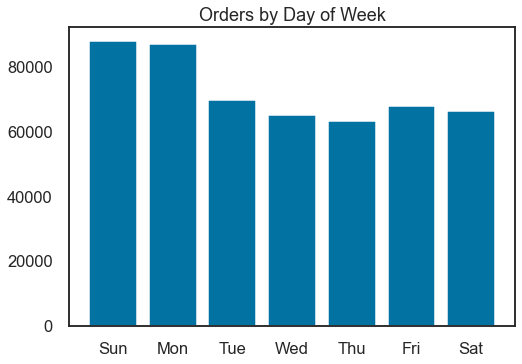

In [39]:
# Visualize orders by day of week
# Assume that 0 = Sunday
days = {0:'Sun', 1:'Mon', 2:'Tue', 3:'Wed', 4:'Thu', 5:'Fri', 6:'Sat'}
values = [orders.order_dow.value_counts()[day] for day in days.keys()]
plt.bar(days.values(), values)
plt.title('Orders by Day of Week')
plt.show();

### Busiest time of day

At what times of day are the most orders placed?

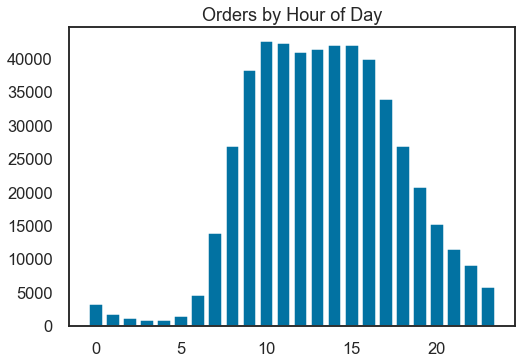

In [40]:
# Visualize orders by hour of day
plt.bar(orders.order_hour_of_day.value_counts().index, 
        orders.order_hour_of_day.value_counts())
plt.title('Orders by Hour of Day')
plt.show();

The busiest part of the day is 10 AM-4 PM.

Is this any different on Sunday, the busiest day of the week?

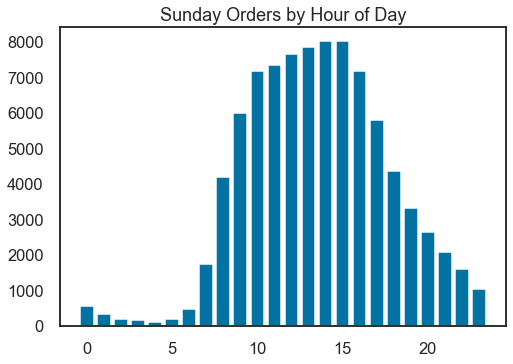

In [41]:
# Visualize Sunday orders by hour of day
sundays = orders[orders.order_dow == 0]
plt.bar(sundays.order_hour_of_day.value_counts().index, 
        sundays.order_hour_of_day.value_counts())
plt.title('Sunday Orders by Hour of Day')
plt.show();

Apparently Sunday has a similar distribution of orders per hour.

Let's compare the hourly distributions of orders from one day to the next.

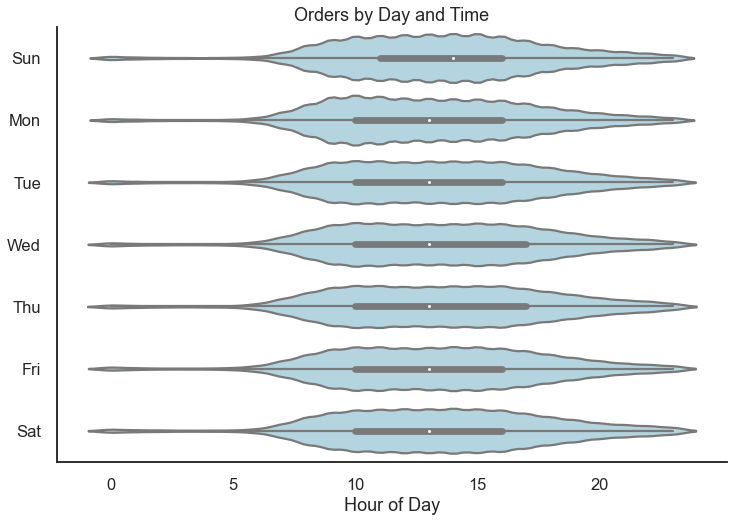

In [42]:
# Visualize distributions of orders by hour per day
plt.figure(figsize=(12, 8))
sns.violinplot(orders.order_hour_of_day, orders.order_dow, orient='h', 
               color='lightblue')
plt.yticks(range(7), [days[n] for n in range(7)])
plt.xticks([0, 5, 10, 15, 20], [0, 5, 10, 15, 20])
plt.xlabel('Hour of Day')
plt.ylabel('')
plt.title('Orders by Day and Time')
sns.despine()
plt.savefig('orders_day_time.png', dpi=300, pad_inches=0.5)
plt.show();

I can see some slight shifts in the median hour from day to day, but overall, every day follows the same pattern of peak and off-peak hours.

### Size of order (in products)

How many products do orders contain?

In [43]:
# Query the database and load the data
cur.execute("""
    SELECT order_id, COUNT(*) AS num_products
    FROM order_products__prior
    GROUP BY order_id
            ;""")
prod_counts = pd.DataFrame(cur.fetchall())
prod_counts.columns = [x[0] for x in cur.description]
prod_counts.head()

,order_id,num_products
0,2,9
1,3,5
2,7176,3
3,4,8
4,7177,2


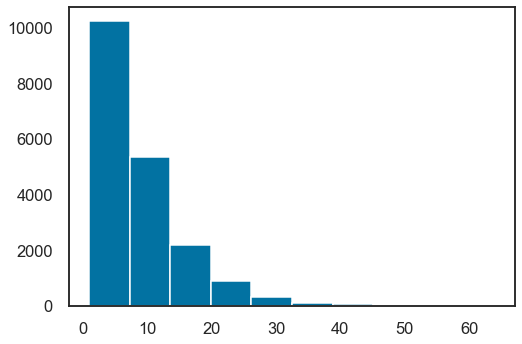

In [44]:
# Visualize distribution of product counts by order
plt.hist(prod_counts.num_products);

In [45]:
# View summary stats
prod_counts.describe()

,order_id,num_products
count,19209.000000,19209.000000
mean,10179.622781,8.820345
std,5832.007331,7.049547
min,2.000000,1.000000
25%,5198.000000,4.000000
50%,10174.000000,7.000000
75%,15191.000000,12.000000
max,20390.000000,64.000000


Most orders are on the small side, with a mean of 10 items, but they range up to 102 items.

How does order size vary by day?

In [46]:
# Query the database and load the data
cur.execute("""
    SELECT o.order_id, 
           o.order_dow,
           COUNT(op.product_id) AS num_products
    FROM orders1 AS o
    INNER JOIN order_products__prior AS op
    ON o.order_id = op.order_id
    GROUP BY o.order_dow, o.order_id
            ;""")
dow_prod_count = pd.DataFrame(cur.fetchall())
dow_prod_count.columns = [x[0] for x in cur.description]
dow_prod_count.head()

,order_id,order_dow,num_products
0,40,1,4
1,214,0,5
2,178,3,2
3,74,5,9
4,85,5,7


In [47]:
# Calculate average order size per day
dow_prod_count.groupby('order_dow')['num_products'].mean()

order_dow
0    9.008584
1    8.734226
2    8.401478
3    8.386243
4    7.729970
5    9.407713
6    9.297003
Name: num_products, dtype: float64

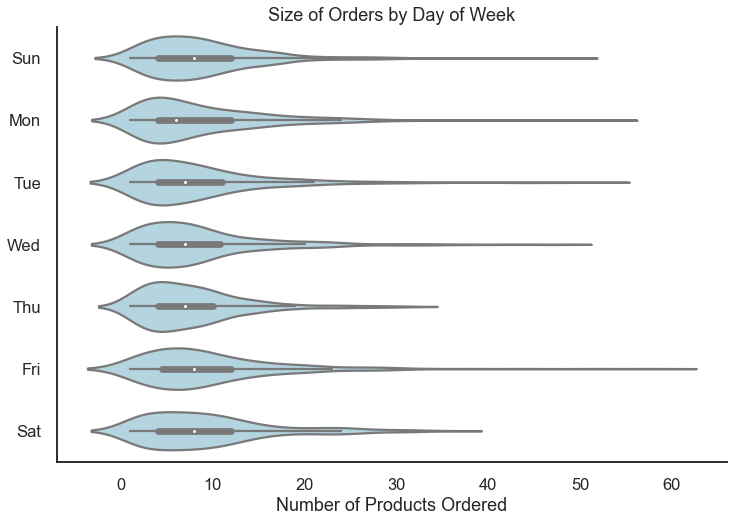

In [48]:
# Visualize distribution of order sizes by day of week
plt.figure(figsize=(12, 8))
sns.violinplot(dow_prod_count.num_products, dow_prod_count.order_dow, 
               orient='h', color='lightblue')
# plt.axvline(x=dow_prod_count.num_products.median(), linestyle='--', 
#             color='r', label='Overall median order size')
plt.yticks(range(7), [days[n] for n in range(7)])
plt.xlabel('Number of Products Ordered')
plt.ylabel('')
plt.title('Size of Orders by Day of Week')
# plt.legend()
sns.despine()
plt.savefig('order_size_by_day.png', dpi=300, pad_inches=0.5)
plt.show();

There is not much apparent difference in order size by day. I'll explore this further in the hypothesis test below.

What about variations in order size by time of of day?

In [49]:
# Query the database and load the data
cur.execute("""
    SELECT o.order_id, 
           o.order_hour_of_day AS hour,
           COUNT(op.product_id) AS num_products
    FROM orders1 AS o
    INNER JOIN order_products__prior AS op
    ON o.order_id = op.order_id
    GROUP BY o.order_dow, o.order_id
            ;""")
hour_prod_count = pd.DataFrame(cur.fetchall())
hour_prod_count.columns = [x[0] for x in cur.description]
hour_prod_count.head()

,order_id,hour,num_products
0,40,15,4
1,214,16,5
2,178,11,2
3,74,21,9
4,85,11,7


In [50]:
# Calculate average order size per hour
hour_prod_count.groupby('hour')['num_products'].mean()

hour
0      7.269231
1      6.888889
2      5.428571
3      8.500000
4      6.375000
5      9.555556
6     12.120000
7      9.842105
8      9.452055
9      9.280193
10     8.353659
11     8.540084
12     8.866953
13     8.346320
14     8.696203
15     8.346491
16     8.572016
17     8.716578
18     7.903448
19     8.190909
20     8.914894
21     9.294118
22    10.389831
23    11.136364
Name: num_products, dtype: float64

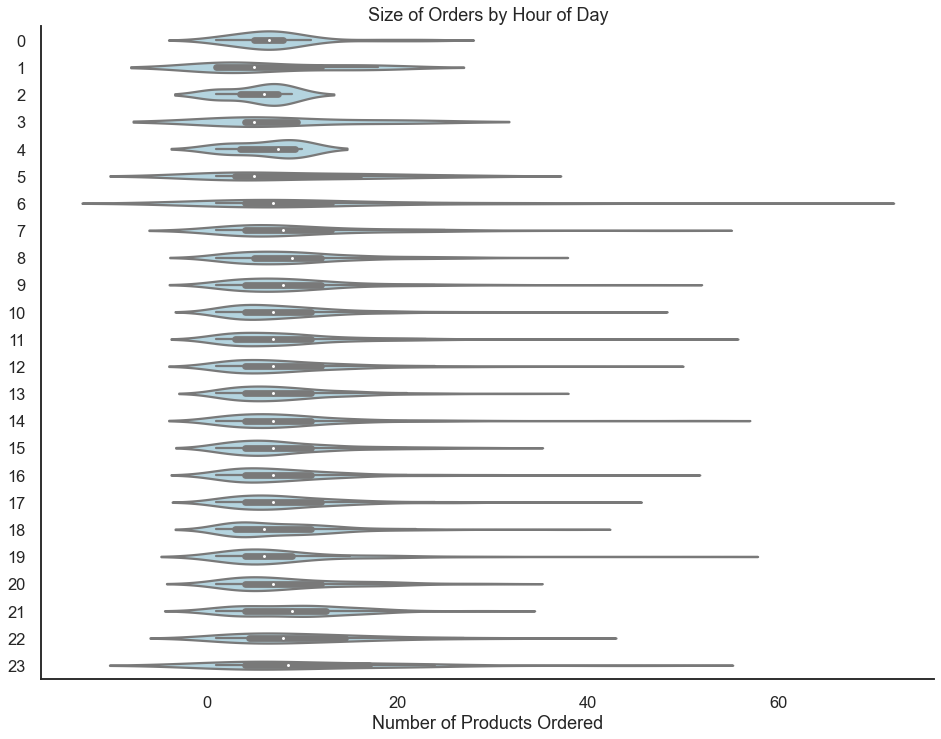

In [51]:
# Visualize distribution of order sizes by hour
plt.figure(figsize=(16, 12))
sns.violinplot(hour_prod_count.num_products, hour_prod_count.hour, orient='h', 
               color='lightblue')
# plt.axvline(x=hour_prod_count.num_products.median(), linestyle='--', 
#             color='r', label='Overall median order size')
plt.yticks(range(24), [n for n in range(24)])
plt.xlabel('Number of Products Ordered')
plt.ylabel('')
plt.title('Size of Orders by Hour of Day')
# plt.legend()
sns.despine()
plt.savefig('order_size_by_hour.png', dpi=300, pad_inches=0.5)
plt.show();

It seems that orders of any size can occur at any time of day. Not much to write home about, but worth confirming that there's no outstanding pattern here.

### Percent of reordered products per order

How many products in each order were also in a previous order by the same customer?

In [52]:
# Query the database and load the data
cur.execute("""
    SELECT order_id, AVG(reordered) AS reorder_rate
    FROM order_products__prior
    GROUP BY order_id
    HAVING AVG(reordered) <= 1
            ;""")
reorder_rate = pd.DataFrame(cur.fetchall())
reorder_rate.columns = [x[0] for x in cur.description]
reorder_rate.head()

,order_id,reorder_rate
0,2,0.6667
1,3,1.0000
2,7176,1.0000
3,4,0.8750
4,7177,1.0000


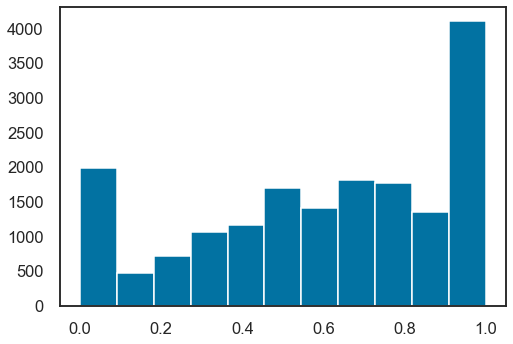

In [53]:
# Plot distribution of reorder rates
plt.hist(reorder_rate.reorder_rate, bins=11);

It appears that some orders contain all new products for that customer, while others contain all products that that customer has ordered before. Most orders are in the middle somewhere.

In [54]:
# View summary stats on reorder rates
reorder_rate.reorder_rate.describe()

count      17558
unique       381
top       1.0000
freq        3731
Name: reorder_rate, dtype: object

What can we learn about orders where every item was reordered?

In [55]:
# Query the database and load the data
cur.execute("""
    SELECT order_id,
           COUNT(product_id) AS num_products,
           AVG(reordered) AS reorder_rate
    FROM order_products__prior
    GROUP BY order_id
    HAVING AVG(reordered) = 1.0
            ;""")
only_reorder = pd.DataFrame(cur.fetchall())
only_reorder.columns = [x[0] for x in cur.description]
only_reorder.head()

,order_id,num_products,reorder_rate
0,3,5,1.0000
1,7176,3,1.0000
2,7177,2,1.0000
3,15,3,1.0000
4,19,2,1.0000


In [56]:
# View summary stats on orders that contained only reordered items
only_reorder.num_products.describe()

count    3731.000000
mean        4.450013
std         3.773743
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        33.000000
Name: num_products, dtype: float64

Orders where all items were reordered contain 5 items on average, ranging between 1 and 80 items.

What about orders with some or all new items?

In [57]:
# Query the database and load the data
cur.execute("""
    SELECT order_id,
           COUNT(product_id) AS num_products,
           AVG(reordered) AS reorder_rate
    FROM order_products__prior
    GROUP BY order_id
    HAVING AVG(reordered) != 1.0
            ;""")
not_only_reorder = pd.DataFrame(cur.fetchall())
not_only_reorder.columns = [x[0] for x in cur.description]
not_only_reorder.head()

,order_id,num_products,reorder_rate
0,2,9,0.6667
1,4,8,0.8750
2,5,18,1.1667
3,7178,16,0.8125
4,6,3,0.0000


In [58]:
# View summary stats on orders that were not only reordered items
not_only_reorder.num_products.describe()

count    15478.000000
mean         9.873821
std          7.247748
min          1.000000
25%          5.000000
50%          8.000000
75%         13.000000
max         64.000000
Name: num_products, dtype: float64

These orders tend to be a little larger on average.

What are the items that get reordered?

In [59]:
# Query the database and load the data
cur.execute("""
    SELECT o.user_id, op.order_id, p.product_id, p.product_name
    FROM orders1 AS o
    JOIN order_products__prior AS op
    ON o.order_id = op.order_id
    JOIN products AS p
    ON op.product_id = p.product_id 
    WHERE op.order_id IN
        (SELECT order_id
        FROM order_products__prior
        GROUP BY order_id
        HAVING AVG(reordered) = 1.0)
            ;""")
freq_reorder = pd.DataFrame(cur.fetchall())
freq_reorder.columns = [x[0] for x in cur.description]
freq_reorder.head()

,user_id,order_id,product_id,product_name
0,137,16785,1674,Moose Tracks Ice Cream
1,208,3449,45223,Just Green Unsweetened Tea
2,222,4163,432,Vanilla Almond Breeze Almond Milk
3,323,12404,27966,Organic Raspberries
4,323,12404,47209,Organic Hass Avocado


I chose not explore this any further because the choice of items to reorder seems very specific to each customer, and that's not something I'm interested in at this time.

### Most popular items

What individual items do customers order the most?

In [60]:
# Query the database and load the data
cur.execute("""
    SELECT p.product_id,
           p.product_name,
           p.aisle_id,
           p.department_id,
           COUNT(op.product_id) AS count
    FROM products AS p
    LEFT JOIN order_products__prior AS op
    ON p.product_id = op.product_id
    GROUP BY 1, 2, 3, 4
            ;""")
popular = pd.DataFrame(cur.fetchall())
popular.columns = [x[0] for x in cur.description]
popular.head()

,product_id,product_name,aisle_id,department_id,count
0,34,Peanut Butter Cereal,121,14,36
1,45,European Cucumber,83,4,104
2,86,"Camilia, Single Liquid Doses",6,2,1
3,148,Nectarines,24,4,18
4,162,Organic Mini Homestyle Waffles,52,1,26


In [61]:
# View summary stats on counts of products ordered
popular['count'].describe()

count    42800.000000
mean         3.340748
std         25.270820
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max       2498.000000
Name: count, dtype: float64

The average item was ordered 79 times, but apparently some items were ordered thousands of times!

Let's focus on the top 10 most popular items by overall quantities ordered.

In [62]:
# View top 10 most popular items by quantity ordered
top_pop = popular.sort_values(by='count', ascending=False)
top_pop[:10]

,product_id,product_name,aisle_id,department_id,count
580,24852,Banana,24,4,2498
305,13176,Bag of Organic Bananas,24,4,2029
488,21137,Organic Strawberries,24,5025,1328
509,21903,Organic Baby Spinach,123,4,1253
1171,47209,Organic Hass Avocado,24,5810,1103
1181,47626,Large Lemon,24,4,788
680,27966,Organic Raspberries,123,4,717
623,26209,Limes,1579881,5199,710
679,27845,Organic Whole Milk,84,16,695
532,22935,Organic Yellow Onion,1974186,5099,584


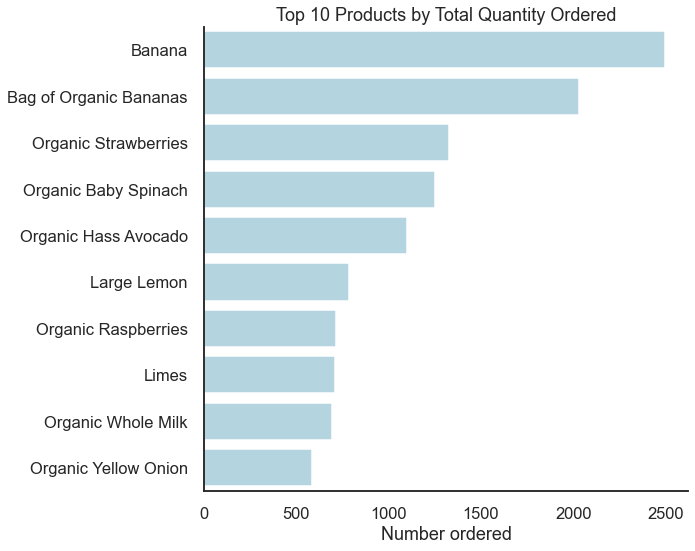

In [63]:
# Visualize counts of most popular items
plt.figure(figsize=(10,8))
sns.barplot(x='count', y='product_name', data=top_pop[:10], 
            color='lightblue');
plt.xlabel('Number ordered')
plt.ylabel('')
plt.title('Top 10 Products by Total Quantity Ordered')
plt.tight_layout()
sns.despine()
plt.savefig('top_10_products.png', dpi=300, pad_inches=2.0)
plt.show();

There's a theme here: the most popular items are fresh produce (plus milk). Bananas are probably so high because...well, who buys just one banana?

### Busiest aisle/dept

From which aisles and departments were the most products ordered?

In [64]:
# Query the database and load the data
cur.execute("""
    SELECT p.product_id,
           p.product_name,
           p.aisle_id,
           a.aisle,
           p.department_id,
           d.department,
           COUNT(op.product_id) AS count
    FROM products AS p
    LEFT JOIN order_products__prior AS op
    ON p.product_id = op.product_id
    LEFT JOIN departments AS d
    ON p.department_id = d.department_id
    LEFT JOIN aisles AS a
    ON p.aisle_id = a.aisle_id
    GROUP BY 1, 2, 3, 4, 5, 6
            ;""")
depts = pd.DataFrame(cur.fetchall())
depts.columns = [x[0] for x in cur.description]
depts.head()

,product_id,product_name,aisle_id,aisle,department_id,department,count
0,34,Peanut Butter Cereal,121,cereal,14,breakfast,36
1,45,European Cucumber,83,fresh vegetables,4,produce,104
2,86,"Camilia, Single Liquid Doses",6,other,2,other,1
3,148,Nectarines,24,fresh fruits,4,produce,18
4,162,Organic Mini Homestyle Waffles,52,frozen breakfast,1,frozen,26


In [65]:
# Calculate products ordered per department and sort descending
by_dept = (pd.DataFrame(depts.groupby(['department_id', 'department'])['count']
                        .sum()).reset_index())
by_dept.sort_values('count', ascending=False, inplace=True)

In [66]:
# Capitalize department names
by_dept['department'] = [x.capitalize() for x in by_dept['department']]
by_dept.head()

,department_id,department,count
3,4,Produce,29765
15,16,Dairy eggs,19008
17,19,Snacks,10154
6,7,Beverages,9475
0,1,Frozen,7041


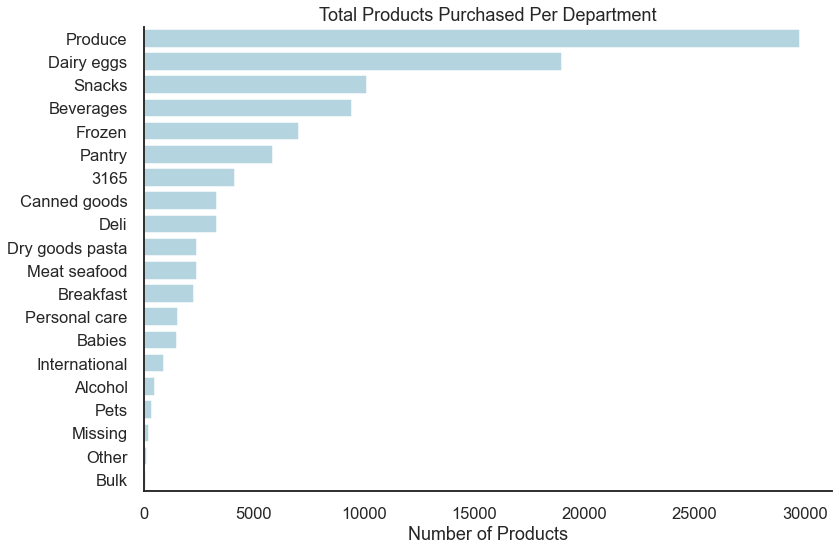

In [67]:
# Visualize total products purchased per department
plt.figure(figsize=(12,8))
sns.barplot(x='count', y='department', data=by_dept, orient='h', 
            color='lightblue')
plt.title('Total Products Purchased Per Department')
plt.xlabel('Number of Products')
plt.ylabel('')
sns.despine()
plt.tight_layout()
plt.savefig('total_prod_dept.png', dpi=300, pad_inches=2.0)
plt.show();

Going by departments, produce is the leader by far. This makes sense given what we saw above with the most popular individual products. Note that produce and dairy are both types of items that would suffer in a hot car; this could have serious implications for labor allocation in warm places and seasons. The company would want to be sure that each worker could collect and deliver these perishable items as quickly as possible, which might mean getting more workers on duty during peak hours.

In [68]:
# Calculate products ordered per aisle and sort descending
by_aisle = (pd.DataFrame(depts.groupby(['aisle_id', 'aisle'])['count']
                         .sum()).reset_index())
by_aisle.sort_values('count', ascending=False, inplace=True)
by_aisle['aisle'] = [x.capitalize() for x in by_aisle['aisle']]

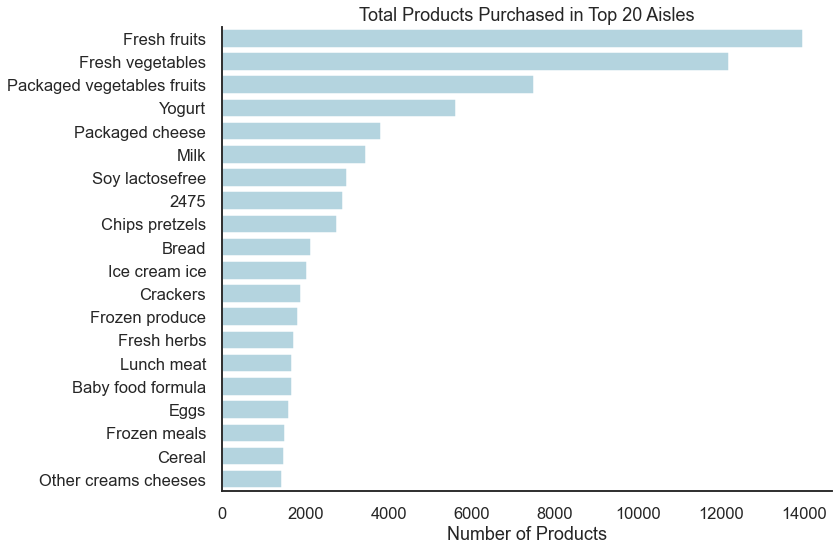

In [69]:
# Visualize top 20 aisles by products ordered
plt.figure(figsize=(12,8))
sns.barplot(x='count', y='aisle', data=by_aisle[:20], orient='h', 
            color='lightblue')
plt.title('Total Products Purchased in Top 20 Aisles')
plt.xlabel('Number of Products')
plt.ylabel('')
plt.tight_layout()
sns.despine()
plt.savefig('total_prod_aisle.png', dpi=300, pad_inches=2.0)
plt.show();

The same goes for aisles as for departments: produce and dairy are the pillars of this business in terms of volume alone. (Without data on revenue, volume is all I have to go on.)

## Customer segmentation

If I can figure out a way to easily sort the customers in meaningful segments, a marketing department could use that information to plan campaigns targeted to the needs and opportunities of each segment. I'll use k-means clustering to do this. 

First, let's review what we can know about each user.

### Inspect the records of an individual user

In [70]:
# Inspect the records of an individual user
user_2 = orders[orders.user_id == 2]
user_2

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
10,1501582,2,prior,2,5,10,10
11,1901567,2,prior,3,1,10,3
12,738281,2,prior,4,2,10,8
13,1673511,2,prior,5,3,11,8
14,1199898,2,prior,6,2,9,13
15,3194192,2,prior,7,2,12,14
16,788338,2,prior,8,1,15,27
17,1718559,2,prior,9,2,9,8
18,1447487,2,prior,10,1,11,6
19,1402090,2,prior,11,1,10,30


In [74]:
# Test how .mean() will handle the NaN at every first order
round(user_2.days_since_prior_order.mean(),0)

16.0

No handles with labels found to put in legend.


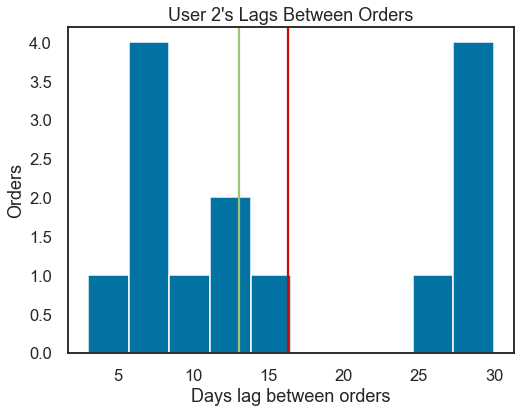

In [72]:
# Visualize distribution of user's lags between orders
# Note that plt.hist() isn't happy about the NaN
plt.figure(figsize=(8,6))
plt.hist(user_2.days_since_prior_order)
plt.axvline(user_2.days_since_prior_order.mean(), color='r')
plt.axvline(user_2.days_since_prior_order.median(), color='g')
plt.xlabel('Days lag between orders')
plt.ylabel('Orders')
plt.title('User 2\'s Lags Between Orders')
plt.legend()
plt.show();

### Feature engineering

In the absence of data I can use for an RFM (recency, frequency, monetary) analysis, I'll need to engineer some features that I think will be meaningful. Here's what I want to try:

For each customer:
- total number of orders
- mean lag between orders
- mean number of products per order
- median hour of order
- rate of peak-day ordering
- rate of peak-time ordering

I'll try clustering three times: once with this full feature set, once with the first three features, and once with the last three features. The first three features are the most similar to RFM, so that's where I'm hoping things will work out.

### Acquire needed data

Here I gather and transform the data I need to make the features outlined above.

In [75]:
# Query the database and load the data
cur.execute("""
    SELECT order_id,
           COUNT(product_id) AS num_products
    FROM order_products__prior
    GROUP BY 1
            ;""")
prod_counts = pd.DataFrame(cur.fetchall())
prod_counts.columns = [x[0] for x in cur.description]
prod_counts.head()

,order_id,num_products
0,2,9
1,3,5
2,7176,3
3,4,8
4,7177,2


In [76]:
# Set index to facilitate joining
prod_counts.set_index('order_id', inplace=True)
prod_counts.head()

,num_products
order_id,
2,9
3,5
7176,3
4,8
7177,2


In [77]:
# Join orders to prod_counts
user_data = orders.join(prod_counts, how='inner', on='order_id')
user_data.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,num_products
93,19256,13,prior,4,1,12,9,2
251,8382,23,prior,2,0,10,9,8
349,7099,27,prior,63,3,10,1,5
469,14400,36,prior,10,1,18,1,2
555,19190,42,prior,3,1,19,7,4


In [78]:
# Check length of resulting DataFrame
len(user_data)

2840

#### Calculate total number of orders per customer

In [79]:
# Calculate total number of orders per customer
num_orders = user_data.groupby('user_id')['order_number'].max()

#### Calculate rate at which each customer orders on peak days

In [80]:
# Create boolean column to record whether order occurred on a peak day
user_data['order_on_peak'] = np.where(user_data['order_dow'] <=1, 1, 0)
user_data.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,num_products,order_on_peak
93,19256,13,prior,4,1,12,9,2,1
251,8382,23,prior,2,0,10,9,8,1
349,7099,27,prior,63,3,10,1,5,0
469,14400,36,prior,10,1,18,1,2,1
555,19190,42,prior,3,1,19,7,4,1


In [81]:
# Calculate rate of peak day ordering per customer
peakday_rate = round(user_data.groupby('user_id')['order_on_peak'].mean(), 2)
peakday_rate.value_counts()

0.00    1641
1.00     849
0.50      93
0.33       9
0.67       6
0.25       1
Name: order_on_peak, dtype: int64

#### Calculate median hour of day at which each customer places their orders

In [82]:
# Calculate median ordering hour per user
med_hour = round(user_data.groupby('user_id')['order_hour_of_day'].median(), 0)
med_hour.head()

user_id
13    12.0
23    10.0
27    10.0
36    18.0
42    19.0
Name: order_hour_of_day, dtype: float64

#### Calculate rate at which each customer orders during peak hours

In [83]:
# Create boolean column to record whether order occured during peak hours
# Peak hours defined as interquartile range of order times
user_data['peak_time'] = np.where((user_data.order_hour_of_day >= 10) 
                                  & (user_data.order_hour_of_day <= 16), 1, 0)
user_data.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,num_products,order_on_peak,peak_time
93,19256,13,prior,4,1,12,9,2,1,1
251,8382,23,prior,2,0,10,9,8,1,1
349,7099,27,prior,63,3,10,1,5,0,1
469,14400,36,prior,10,1,18,1,2,1,0
555,19190,42,prior,3,1,19,7,4,1,0


In [84]:
# Calculate rate of peak time ordering per customer
peaktime_rate = round(user_data.groupby('user_id')['peak_time'].mean(), 2)
peaktime_rate.value_counts()

1.00    1457
0.00    1031
0.50      97
0.67      10
0.33       3
0.75       1
Name: peak_time, dtype: int64

#### Calculate average lag between orders per customer

In [85]:
# Calculate mean lag per customer
mean_lag = round(user_data.groupby('user_id')['days_since_prior_order'].mean(), 0)
mean_lag.head()

user_id
13    9.0
23    9.0
27    1.0
36    1.0
42    7.0
Name: days_since_prior_order, dtype: float64

#### Calculate mean number of products ordered per customer

In [86]:
# Calculate mean products ordered per customer
mean_products = round(user_data.groupby('user_id')['num_products'].mean(), 0)
mean_products.head()

user_id
13    2.0
23    8.0
27    5.0
36    2.0
42    4.0
Name: num_products, dtype: float64

#### Concatenate and transform all the new features

In [87]:
# Concatenate new features into one DataFrame
features = pd.concat([num_orders, peakday_rate, med_hour, peaktime_rate, 
                      mean_lag, mean_products], axis=1)
features.columns = ['num_orders', 'peakday_rate', 'med_hour', 'peaktime_rate', 
                    'mean_lag', 'mean_products']
features.head()

,num_orders,peakday_rate,med_hour,peaktime_rate,mean_lag,mean_products
user_id,,,,,,
13,4,1.0,12.0,1.0,9.0,2.0
23,2,1.0,10.0,1.0,9.0,8.0
27,63,0.0,10.0,1.0,1.0,5.0
36,10,1.0,18.0,0.0,1.0,2.0
42,3,1.0,19.0,0.0,7.0,4.0


In [88]:
# Check for missing values
features.isna().sum()

num_orders       0
peakday_rate     0
med_hour         0
peaktime_rate    0
mean_lag         0
mean_products    0
dtype: int64

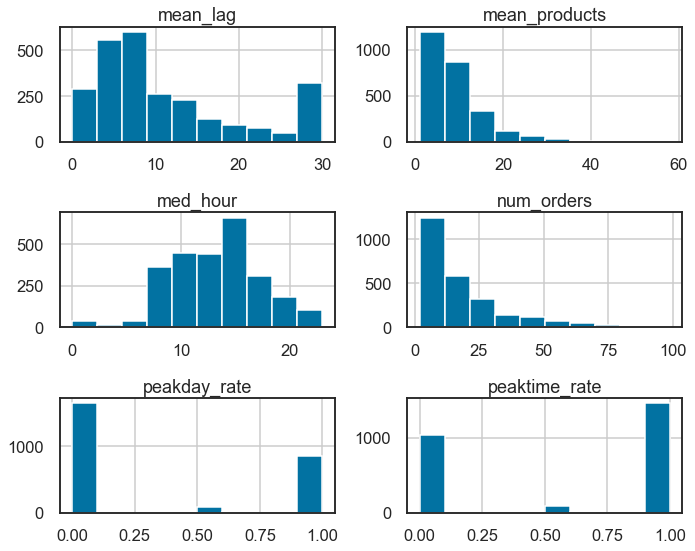

In [89]:
# Visualize distribution of each feature
features.hist(figsize=(10,8))
plt.tight_layout();

I can see that `num_orders` is skewed positively, so I'll log-transform it. The others are roughly normally distributed.

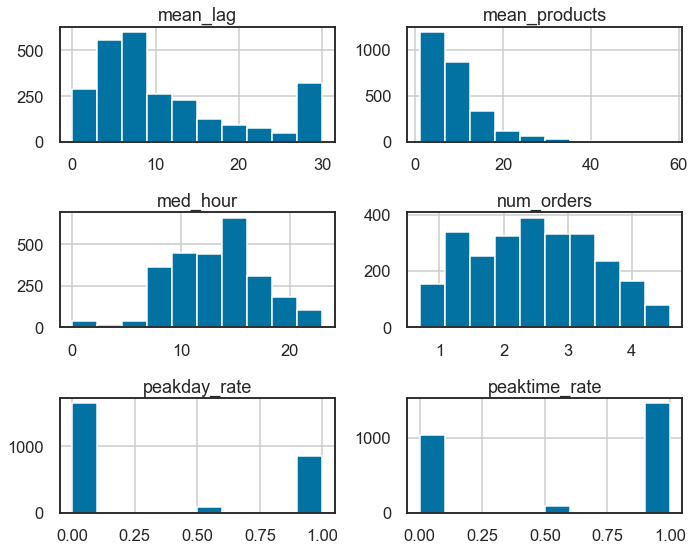

In [90]:
# Log-transform `num_orders` and replot features
features['num_orders'] = np.log(features['num_orders'])
features.hist(figsize=(10,8))
plt.tight_layout();

The distributions now look good. Next I need to standardize the features so they have mean = 0 and standard deviation = 1. K-means is easily influence by outliers, and standardization helps mitigate that.

In [91]:
# Scale the features
scaler = StandardScaler()
feat_scaled = scaler.fit_transform(features)

In [92]:
# Convert to DataFrame and check summary stats
feat_scaled = pd.DataFrame(feat_scaled)
feat_scaled.describe()

,0,1,2,3,4,5
count,2.599000e+03,2.599000e+03,2.599000e+03,2.599000e+03,2.599000e+03,2.599000e+03
mean,-1.680926e-17,-8.509289e-17,-6.809140e-17,3.149120e-16,1.470971e-16,-1.653160e-17
std,1.000192e+00,1.000192e+00,1.000192e+00,1.000192e+00,1.000192e+00,1.000192e+00
min,-1.848776e+00,-7.466661e-01,-3.215040e+00,-1.207590e+00,-1.232299e+00,-1.137171e+00
25%,-7.117858e-01,-7.466661e-01,-8.073498e-01,-1.207590e+00,-7.844411e-01,-6.936450e-01
50%,5.575467e-03,-7.466661e-01,-8.504269e-02,8.654948e-01,-3.365829e-01,-2.501195e-01
75%,7.651848e-01,1.402995e+00,6.372644e-01,8.654948e-01,4.471689e-01,3.412479e-01
max,2.189506e+00,1.402995e+00,2.322647e+00,8.654948e-01,2.126637e+00,7.289814e+00


### Perform KMeans clustering on full feature set

#### Determine best value for k

I'll use two metrics to select the best k: distortion score and silhouette score. Distortion score is a measure of intra-cluster similarity, and silhouette measures inter-cluster similarity.

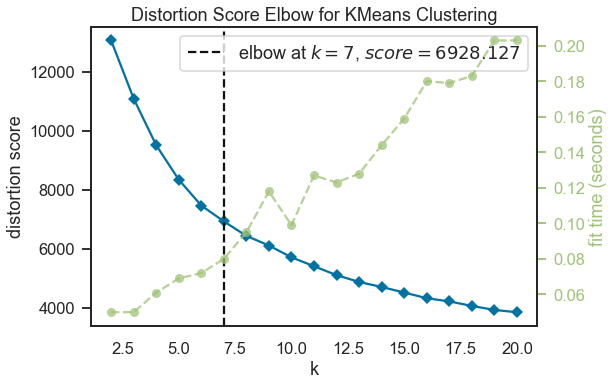

In [93]:
# Visualize performance of KMeans at various values k
# This approaches uses distortion score to evaluate KMeans
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 21))

visualizer.fit(feat_scaled)   
visualizer.show();

No. Clusters: 2, Silhouette Score: 0.198, Change from Previous Cluster: 0.0
No. Clusters: 3, Silhouette Score: 0.241, Change from Previous Cluster: 0.043
No. Clusters: 4, Silhouette Score: 0.245, Change from Previous Cluster: 0.004
No. Clusters: 5, Silhouette Score: 0.246, Change from Previous Cluster: 0.001
No. Clusters: 6, Silhouette Score: 0.253, Change from Previous Cluster: 0.007
No. Clusters: 7, Silhouette Score: 0.217, Change from Previous Cluster: -0.036
No. Clusters: 8, Silhouette Score: 0.231, Change from Previous Cluster: 0.014
No. Clusters: 9, Silhouette Score: 0.253, Change from Previous Cluster: 0.022


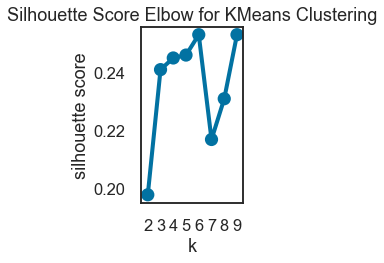

In [94]:
# Evaluate KMeans at various values k
optimal_kmeans(feat_scaled, 2, 10)

Both plots show an elbow at k=7. I'll visualize clusters for 6, 7, and 8 clusters for comparison.

#### Visualize clusters with t-SNE

(             0         1         2         3         4         5  Cluster
 0    -1.131415  1.402995 -0.325812  0.865495 -0.224618 -0.989329        5
 1    -1.848776  1.402995 -0.807350  0.865495 -0.224618 -0.102278        5
 2     1.721731 -0.746666 -0.807350  0.865495 -1.120335 -0.545803        0
 3    -0.183115  1.402995  1.118802 -1.207590 -1.120335 -0.989329        3
 4    -1.429147  1.402995  1.359571 -1.207590 -0.448547 -0.693645        3
 ...        ...       ...       ...       ...       ...       ...      ...
 2594  0.165111 -0.746666 -0.566581  0.865495 -0.448547  0.636932        0
 2595 -1.429147  1.402995  0.155726  0.865495  2.126637  0.045564        4
 2596  0.918790  1.402995 -1.770426 -1.207590 -0.896406 -0.989329        1
 2597  1.440298  1.402995  0.637264  0.865495  0.223240 -0.250119        5
 2598  0.425205  1.402995  0.637264  0.865495 -0.448547  0.932615        5
 
 [2599 rows x 7 columns],
 array([5, 5, 0, ..., 1, 5, 5]))

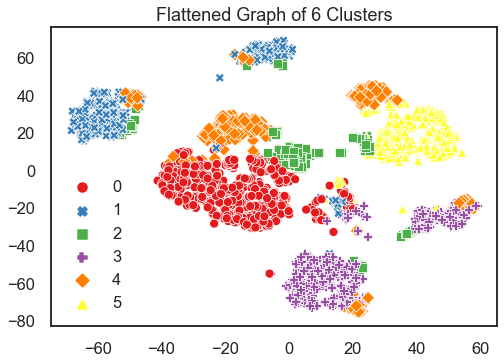

In [95]:
# Visualize clusters for k=6
kmeans(feat_scaled, 6)

(             0         1         2         3         4         5  Cluster
 0    -1.131415  1.402995 -0.325812  0.865495 -0.224618 -0.989329        1
 1    -1.848776  1.402995 -0.807350  0.865495 -0.224618 -0.102278        1
 2     1.721731 -0.746666 -0.807350  0.865495 -1.120335 -0.545803        2
 3    -0.183115  1.402995  1.118802 -1.207590 -1.120335 -0.989329        5
 4    -1.429147  1.402995  1.359571 -1.207590 -0.448547 -0.693645        5
 ...        ...       ...       ...       ...       ...       ...      ...
 2594  0.165111 -0.746666 -0.566581  0.865495 -0.448547  0.636932        3
 2595 -1.429147  1.402995  0.155726  0.865495  2.126637  0.045564        0
 2596  0.918790  1.402995 -1.770426 -1.207590 -0.896406 -0.989329        6
 2597  1.440298  1.402995  0.637264  0.865495  0.223240 -0.250119        1
 2598  0.425205  1.402995  0.637264  0.865495 -0.448547  0.932615        1
 
 [2599 rows x 7 columns],
 array([1, 1, 2, ..., 6, 1, 1]))

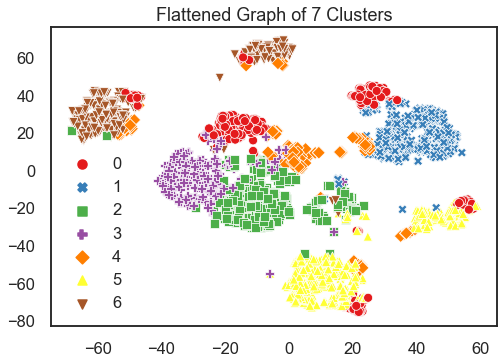

In [96]:
# Visualize clusters for k=7
kmeans(feat_scaled, 7)

(             0         1         2         3         4         5  Cluster
 0    -1.131415  1.402995 -0.325812  0.865495 -0.224618 -0.989329        1
 1    -1.848776  1.402995 -0.807350  0.865495 -0.224618 -0.102278        1
 2     1.721731 -0.746666 -0.807350  0.865495 -1.120335 -0.545803        4
 3    -0.183115  1.402995  1.118802 -1.207590 -1.120335 -0.989329        7
 4    -1.429147  1.402995  1.359571 -1.207590 -0.448547 -0.693645        7
 ...        ...       ...       ...       ...       ...       ...      ...
 2594  0.165111 -0.746666 -0.566581  0.865495 -0.448547  0.636932        0
 2595 -1.429147  1.402995  0.155726  0.865495  2.126637  0.045564        6
 2596  0.918790  1.402995 -1.770426 -1.207590 -0.896406 -0.989329        2
 2597  1.440298  1.402995  0.637264  0.865495  0.223240 -0.250119        1
 2598  0.425205  1.402995  0.637264  0.865495 -0.448547  0.932615        1
 
 [2599 rows x 7 columns],
 array([1, 1, 4, ..., 2, 1, 1]))

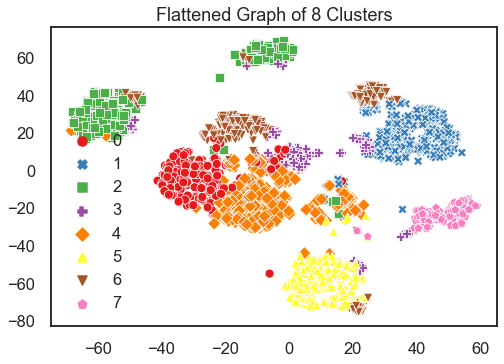

In [97]:
# Visualize clusters for k=8
kmeans(feat_scaled, 8)

All of these clusters are pretty messy. I would not feel very confident assigning customers to clusters on the basis of this feature set.

### Perform KMeans clustering on RFM-like features

Now I'll try the same thing with the first subset of features: number of orders, mean lag between orders, and mean number of products per order.

In [98]:
# Drop unwanted features
features_fewer = features.drop(['med_hour', 'peakday_rate', 'peaktime_rate'], axis=1)

# Scale selected features
scaler = StandardScaler()
feat_few_scaled = scaler.fit_transform(features_fewer)

# Convert to DataFrame
feat_few_scaled = pd.DataFrame(feat_few_scaled)

#### Determine best value for k

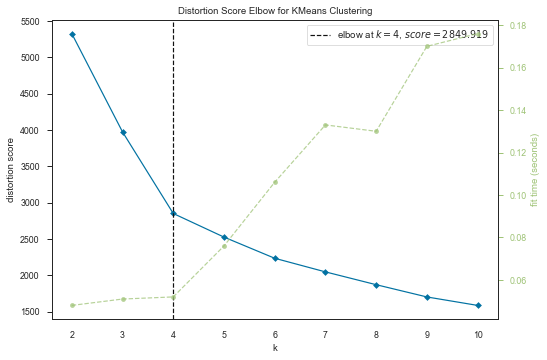

In [99]:
# Evaluate KMeans for various values k
# This method uses distortion score to evaluate KMeans
sns.set_context('paper')
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 11))

visualizer.fit(feat_few_scaled)   
visualizer.show(outpath='elbow_plot_disto.png', dpi=300);

No. Clusters: 2, Silhouette Score: 0.321, Change from Previous Cluster: 0.0
No. Clusters: 3, Silhouette Score: 0.354, Change from Previous Cluster: 0.033
No. Clusters: 4, Silhouette Score: 0.347, Change from Previous Cluster: -0.007
No. Clusters: 5, Silhouette Score: 0.321, Change from Previous Cluster: -0.026
No. Clusters: 6, Silhouette Score: 0.293, Change from Previous Cluster: -0.028
No. Clusters: 7, Silhouette Score: 0.273, Change from Previous Cluster: -0.02
No. Clusters: 8, Silhouette Score: 0.271, Change from Previous Cluster: -0.002
No. Clusters: 9, Silhouette Score: 0.286, Change from Previous Cluster: 0.015
No. Clusters: 10, Silhouette Score: 0.283, Change from Previous Cluster: -0.003


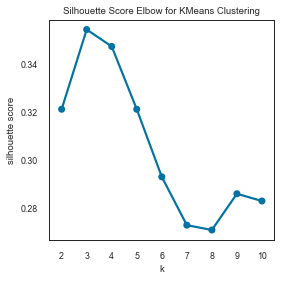

In [100]:
# Evaluate KMeans for various values k
# This method uses silhouette score to evaluate KMeans
optimal_kmeans(feat_few_scaled, 2, 11)

Both metrics point to k=4 as the best option. Once again, I'll visualize 3, 4, and 5 clusters for comparison.

#### Visualize clusters with t-SNE

(             0         1         2  Cluster
 0    -1.131415 -0.224618 -0.989329        1
 1    -1.848776 -0.224618 -0.102278        0
 2     1.721731 -1.120335 -0.545803        1
 3    -0.183115 -1.120335 -0.989329        1
 4    -1.429147 -0.448547 -0.693645        1
 ...        ...       ...       ...      ...
 2594  0.165111 -0.448547  0.636932        1
 2595 -1.429147  2.126637  0.045564        0
 2596  0.918790 -0.896406 -0.989329        1
 2597  1.440298  0.223240 -0.250119        1
 2598  0.425205 -0.448547  0.932615        2
 
 [2599 rows x 4 columns],
 array([1, 0, 1, ..., 1, 1, 2]))

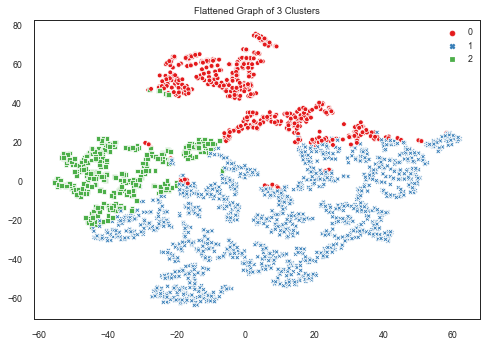

In [101]:
# Plot clusters for k=3
kmeans(feat_few_scaled, 3)

(             0         1         2  Cluster
 0    -1.131415 -0.224618 -0.989329        1
 1    -1.848776 -0.224618 -0.102278        1
 2     1.721731 -1.120335 -0.545803        0
 3    -0.183115 -1.120335 -0.989329        1
 4    -1.429147 -0.448547 -0.693645        1
 ...        ...       ...       ...      ...
 2594  0.165111 -0.448547  0.636932        0
 2595 -1.429147  2.126637  0.045564        3
 2596  0.918790 -0.896406 -0.989329        0
 2597  1.440298  0.223240 -0.250119        0
 2598  0.425205 -0.448547  0.932615        2
 
 [2599 rows x 4 columns],
 array([1, 1, 0, ..., 0, 0, 2]))

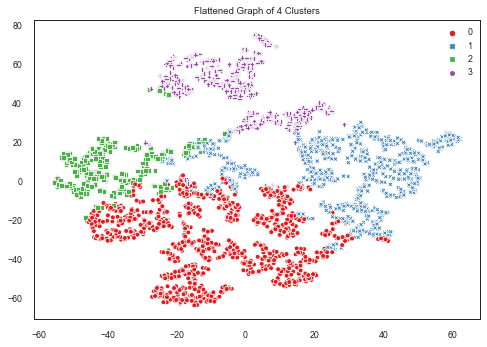

In [102]:
# Plot clusters for k=4
kmeans(feat_few_scaled, 4)

(             0         1         2  Cluster
 0    -1.131415 -0.224618 -0.989329        1
 1    -1.848776 -0.224618 -0.102278        1
 2     1.721731 -1.120335 -0.545803        0
 3    -0.183115 -1.120335 -0.989329        1
 4    -1.429147 -0.448547 -0.693645        1
 ...        ...       ...       ...      ...
 2594  0.165111 -0.448547  0.636932        2
 2595 -1.429147  2.126637  0.045564        3
 2596  0.918790 -0.896406 -0.989329        0
 2597  1.440298  0.223240 -0.250119        0
 2598  0.425205 -0.448547  0.932615        2
 
 [2599 rows x 4 columns],
 array([1, 1, 0, ..., 0, 0, 2]))

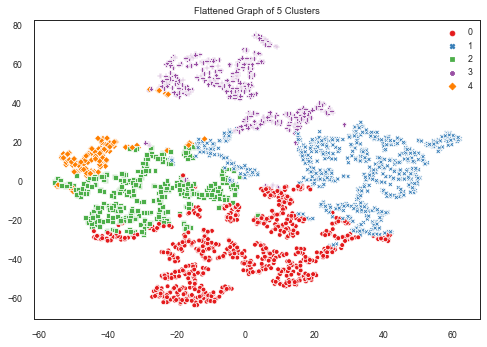

In [103]:
# Plot clusters for k=5
kmeans(feat_few_scaled, 5)

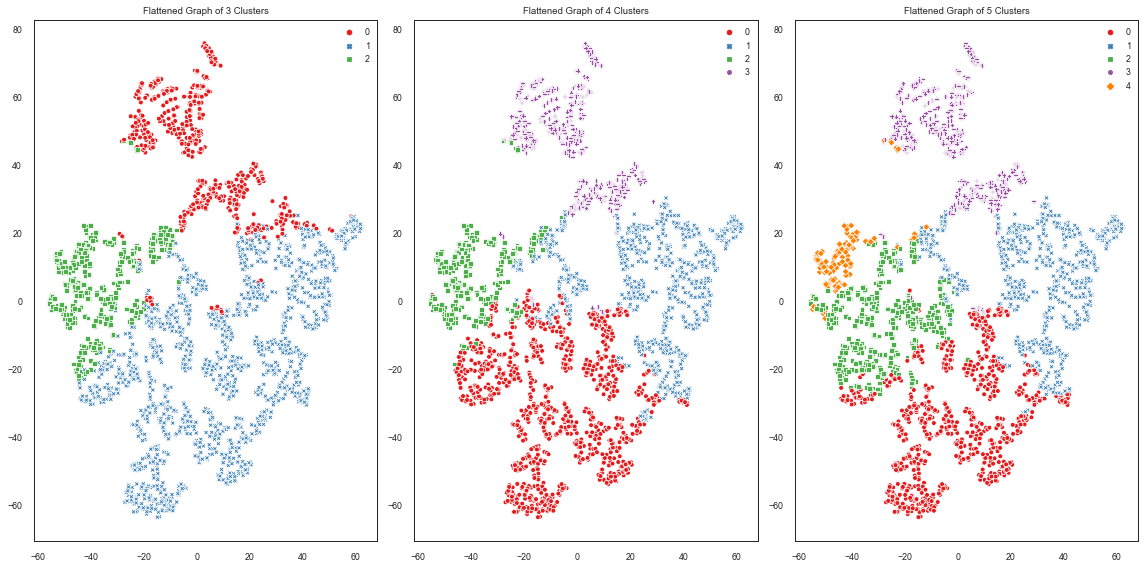

In [104]:
# Create subplots for various k clusters
plt.figure(figsize=(16, 8))

plt.subplot(1, 3, 1)
k3 = kmeans(feat_few_scaled, 3)

plt.subplot(1, 3, 2)
k4 = kmeans(feat_few_scaled, 4)

plt.subplot(1, 3, 3)
k5 = kmeans(feat_few_scaled, 5)

plt.tight_layout()
plt.savefig('various_k_clusters.png', format='png', dpi=300, pad_inches=2.0)
plt.show()

The clusters are most easily separable at k=3. Using these features, I think I can get some useful cluster assignments to give to a marketing team.

### Create snake plot for best clusters

Finally, I'll see what I can learn about each cluster.

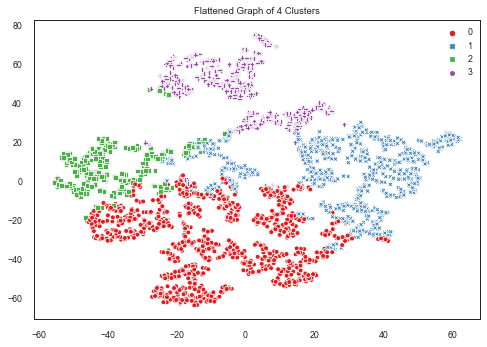

In [105]:
# Extract clusters
k3 = kmeans(feat_few_scaled, 4)

In [106]:
# Convert clusters to DataFrame with appropriate index and column names
cluster_df = pd.DataFrame(k3[0])
cluster_df.index = features_fewer.index
cluster_df.columns = ['Number of Orders', 'Avg. Lag Between Orders', 
                      'Avg. # Products Per Order', 'Cluster']
cluster_df.head()

,Number of Orders,Avg. Lag Between Orders,Avg. # Products Per Order,Cluster
user_id,,,,
13,-1.131415,-0.224618,-0.989329,1
23,-1.848776,-0.224618,-0.102278,1
27,1.721731,-1.120335,-0.545803,0
36,-0.183115,-1.120335,-0.989329,1
42,-1.429147,-0.448547,-0.693645,1


In [107]:
# Reshape data for snake plot
cluster_melt = pd.melt(cluster_df.reset_index(),
                       id_vars=['user_id', 'Cluster'],
                       value_vars=['Number of Orders', 
                                   'Avg. Lag Between Orders', 
                                   'Avg. # Products Per Order'],
                       var_name='Metric',
                       value_name='Value')

The snake plot above summarizes what we know about each cluster. Keep in mind that the values on the y-axis are standardized, so they're not in units that are easy to understand. That's why I've hidden them. Think instead in terms of small, medium, and large numbers of orders, lags, and products per order.

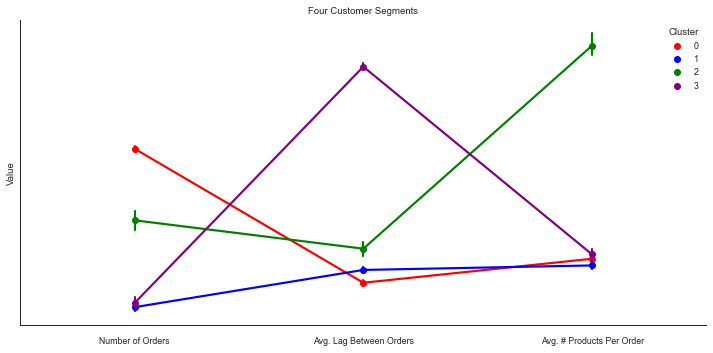

In [108]:
# Create snake plot
palette = ['red', 'blue', 'green', 'purple']
plt.figure(figsize=(10,5))
sns.pointplot(x='Metric', y='Value', data=cluster_melt, hue='Cluster', 
              palette=palette)
plt.xlabel('')
plt.ylabel('Value')
plt.yticks([])
plt.title('Four Customer Segments')
sns.despine()
plt.tight_layout()
plt.savefig('snake_plot.png', dpi=300, pad_inches=2.0)
plt.show();

# Recommendations

- Coordinate labor around peak times
- Focus on produce
- Adjust for local circumstances
- Tailor marketing to customer segments
